In [81]:
!pip install -q timm
from transformers import DetrFeatureExtractor
import torch
import fitz  # PyMuPDF
from PIL import Image
from transformers import TableTransformerForObjectDetection
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import camelot




[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [193]:

def get_image(file_path: str):
# Open the PDF file
    pdf_document = fitz.open(file_path)

    # Iterate through each page
        # Get the page
    page_number = 132
    page = pdf_document.load_page(page_number)
    pix = page.get_pixmap()
    image_path = f"page_{page_number}.png"
    pix.save(image_path)

    # Now you can open and process it with PIL
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    # image.resize((int(width*0.5), int(height*0.5)))
    return image, width, height

# img, width, height = get_image("/Users/danielbasman/Desktop/Desktop - Daniel’s MacBook Pro/MyStuff/Classes/Human In Loop/10-K.pdf")


In [194]:
def extract_features(image, width, height):

  feature_extractor = DetrFeatureExtractor()
  encoding = feature_extractor(image, return_tensors="pt")
  # encoding.keys()
  # print(encoding['pixel_values'].shape)

  model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

  with torch.no_grad():
    outputs = model(**encoding)
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.001, target_sizes=[(height, width)])[0]

    return model, results, feature_extractor
# model, results, feature_extractor = extract_features(img, width, height)

In [195]:

def plot_box(pil_img, boxes):
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    
    ax.add_patch(plt.Rectangle((boxes[1], boxes[2]), boxes[3] - boxes[1], -(boxes[2] - boxes[0]),
                                   fill=False, color='red', linewidth=3))
    
    print("height: ", boxes[2] - boxes[0])
    print("width: ", boxes[3] - boxes[1])
    plt.axis('on')

    plt.show()
    
def plot_results(pil_img, scores, labels, boxes):
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=8,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('on')

    plt.show()

In [196]:
def sort_results(results):

    # width, height = image.size

    max_score_index = torch.argmax(results['scores'])
    max_score = results['scores'][max_score_index]
    max_score_box = results['boxes'][max_score_index]

    left = []
    right = []
    top = []
    bottom = []

    for i in results["boxes"]:
        top.append(i[3])
        right.append(i[2])
        left.append(i[0])
        bottom.append(i[1])
        # print("top y: ", i[3], "bottom y: ", i[1], "right x: ", i[2], "left x: ", i[0])
        
    # print(left)
    final = []

    for i in [bottom, left]:
        # print(i)
        min_value = min(tensor.min() for tensor in i)
        # print(min_value)
        final.append(min_value)

    for i in [top, right]:
        # print(i)
        max_value = max(tensor.max() for tensor in i)
        # print(max_value)
        final.append(max_value)
    # print(final)
    # print("Anchor")
    # print(final[1])
    # print(final[2])
    max_score_box = [max_score_box[3], max_score_box[0], max_score_box[1], max_score_box[2]]
    # print(max_score_box)

    return final, max_score_box

# final, max_score_box = sort_results(results)


In [197]:

def convert_results(results):
    # Converting tensors to lists
    data = {key: value.tolist() for key, value in results.items()}

    # Combining the scores, labels, and boxes into a single list of tuples for sorting
    combined_data = list(zip(data['scores'], data['labels'], data['boxes']))

    # Sorting the combined data by scores in descending order
    sorted_data = sorted(combined_data, key=lambda x: x[0], reverse=True)

    # Reformatting back into the dictionary structure
    sorted_dict = {
        'scores': [item[0] for item in sorted_data],
        'labels': [item[1] for item in sorted_data],
        'boxes': [item[2] for item in sorted_data]
    }

    return sorted_dict

In [198]:
def get_table_image(image, final):
    width, height = image.size
    image.resize((int(width*0.5), int(height*0.5)))

    x =  int(final[1])
    y = int(final[0])
    width = int(final[3] - final[1])
    height = int(final[2] - final[0])
    print(x, y, width, height)
    cropped_image = image.crop((x-30, y-20, x + width + 30, y + height))
    # cropped_image.save('cropped_portion.png')

    return cropped_image

# cropped_image = get_table_image(image, final)


In [199]:
def table_structure_results(cropped_image, feature_extractor):

  image = cropped_image.convert("RGB")

  width, height = image.size
  # image.resize((int(width*0.5), int(height*0.5)))

  encoding = feature_extractor(image, return_tensors="pt")
  # encoding.keys()
  model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

  with torch.no_grad():
    outputs = model(**encoding)

    target_sizes = [image.size[::-1]]
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[0]

    return results, model

# results, model = table_structure_results(cropped_image, feature_extractor)
# print(results)

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


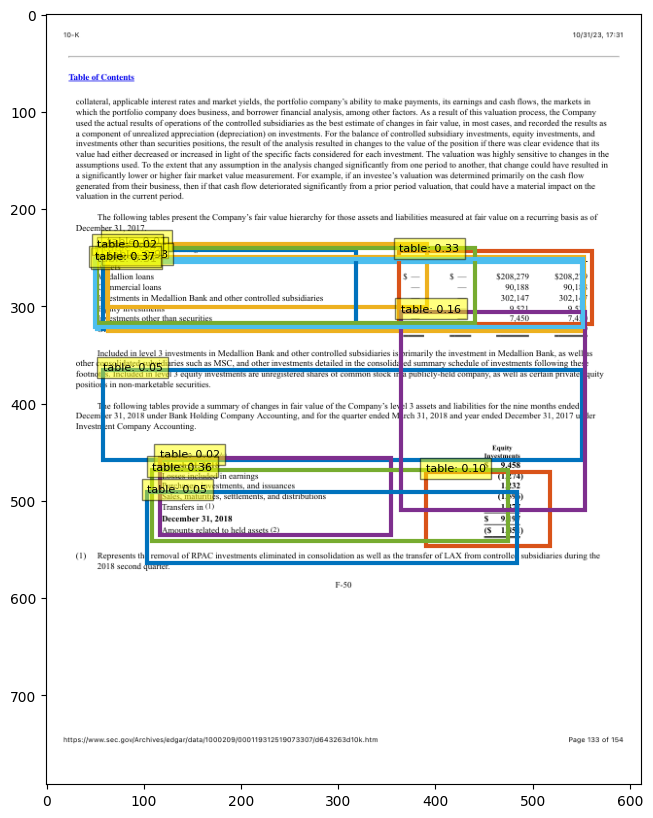

height:  tensor(328.5233)
width:  tensor(511.0070)


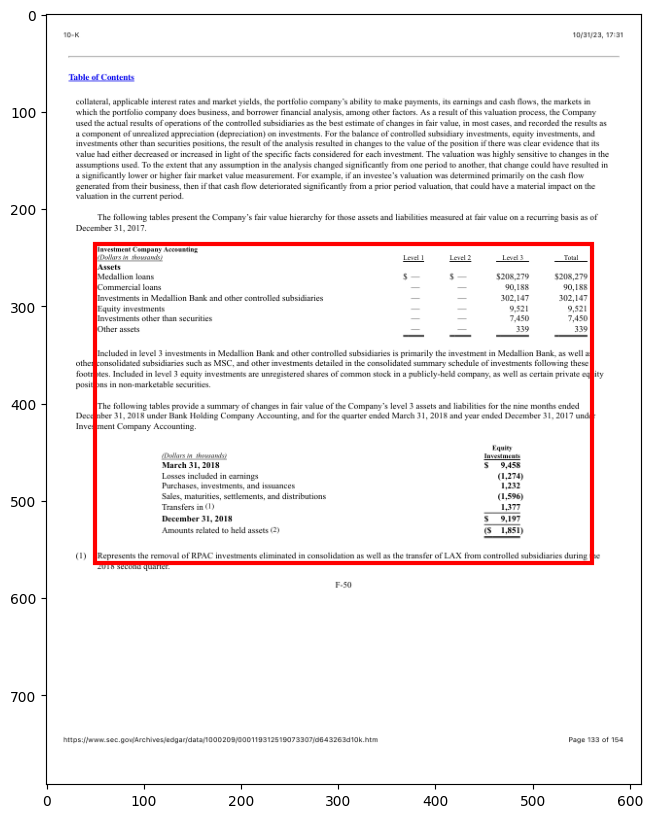

49 235 511 328


Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


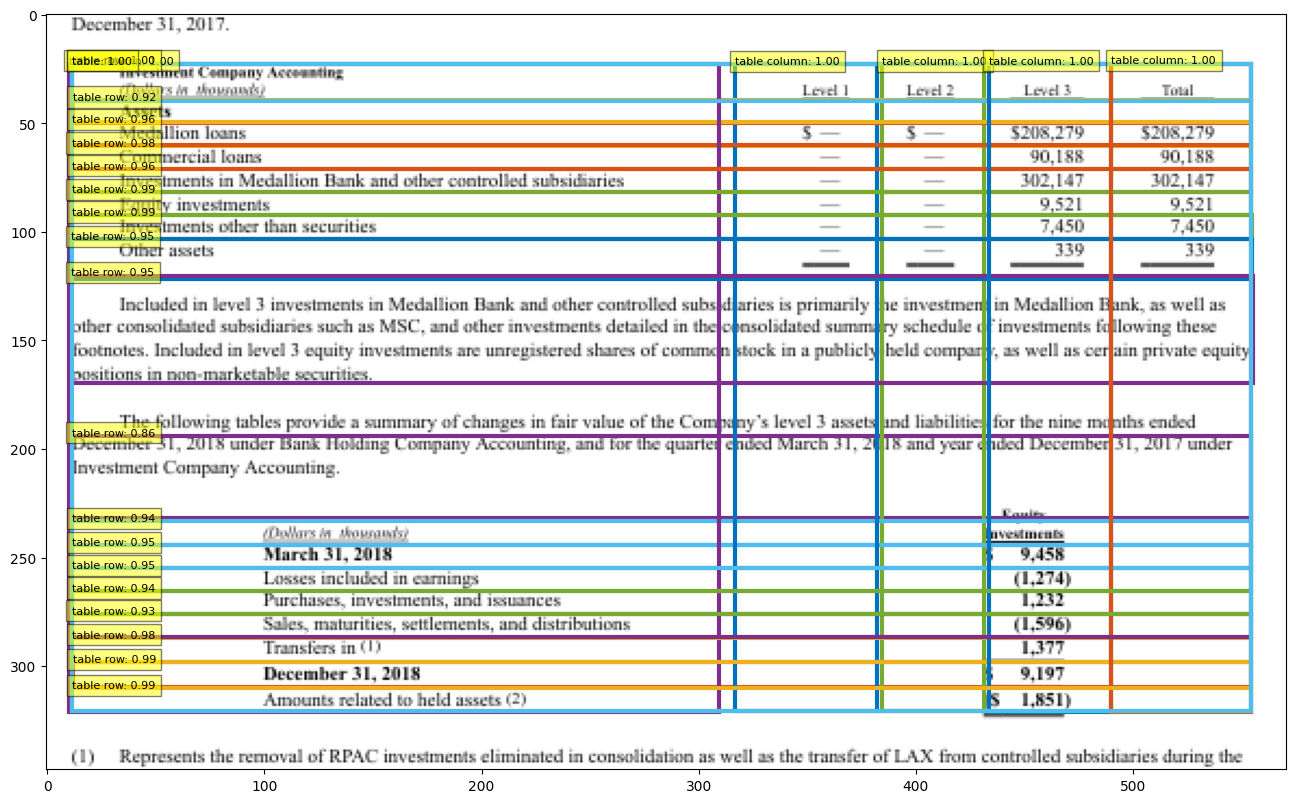

In [200]:
img, width, height = get_image("/Users/danielbasman/Desktop/Desktop - Daniel’s MacBook Pro/MyStuff/Classes/Human In Loop/10-K.pdf")

model, results, feature_extractor = extract_features(img, width, height)
final, max_score_box = sort_results(results)
sorted_dict = convert_results(results)

plot_results(img, results['scores'], results['labels'], results['boxes'])
plot_box(img, final)

cropped_image = get_table_image(img, final)

results, model = table_structure_results(cropped_image, feature_extractor)
plot_results(cropped_image, results['scores'], results['labels'], results['boxes'])

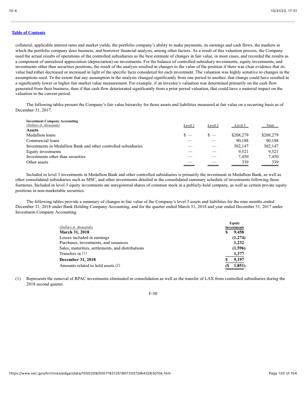

In [614]:
pdf_path = "/Users/danielbasman/Desktop/Desktop - Daniel’s MacBook Pro/MyStuff/Classes/Human In Loop/10-K.pdf"

pdf_document = fitz.open(pdf_path)

# Iterate through each page
    # Get the page
page = pdf_document.load_page(132)
pix = page.get_pixmap()
image_path = f"page_{page_number}.png"
pix.save(image_path)

# Now you can open and process it with PIL
image = Image.open(image_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

[tensor(235.5506), tensor(49.8219), tensor(564.0739), tensor(560.8289)]
[235, 49, 564, 560]
['49', '565', '560', '236']
{'accuracy': 94.76, 'whitespace': 58.33, 'order': 1, 'page': 133}


/var/folders/kn/739d8k5d0gg3fn_85xxj5hvh0000gn/T/ipykernel_1848/1851106678.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind="contour").show()


,0,1,2,3,4,5
0,Investment Company Accounting,,,,,
1,(Dollars in thousands),Level 1,Level 2,,Level 3,Total
2,Assets,,,,,
3,Medallion loans,$ —,$ —,,"$208,279","$208,279"
4,Commercial loans,—,—,,"90,188","90,188"
5,Investments in Medallion Bank and other contro...,—,—,,"302,147","302,147"
6,Equity investments,—,—,,"9,521","9,521"
7,Investments other than securities,—,—,,"7,450","7,450"
8,Other assets,—,—,,339,339
9,,Included in level 3 investments in Medallion B...,,,,


None


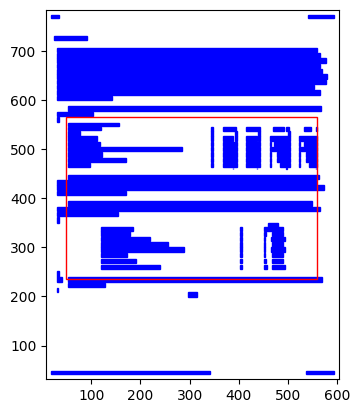

In [615]:

# Replace with the path to your PDF file

print(final)
# convert final from tensors to ints to a list of strings
finals = []
for i in final:
    finals.append((int(i)))

print(finals)
reorder = [str(finals[1]), str(800 - finals[0]), str(finals[3]), str(800 - finals[2])]
print(reorder)
fina = ",".join(reorder)
inpu = ([str(fina)])
tables = camelot.read_pdf(pdf_path, pages='133', flavor='stream', table_areas = inpu)

# Print the extracted tables
# for i, table in enumerate(tables):
#     print(f"Table {i+1}:\n", table.df)
print(tables[0].parsing_report)
camelot.plot(tables[0], kind="contour").show()

print(display(tables[0].df))



In [580]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}